In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create directory if it doesn't exist
!mkdir -p /content/sample_data/dataset

# Unzip the contents
!unzip '/content/drive/MyDrive/dataset.zip' -d '/content/sample_data/dataset/'

GPU(s) detected: 1
GPU(s) detected: 1
Found classes: ['Adposhel', 'Agent', 'Allaple', 'Alueron.gen!J', 'Amonetize', 'Androm', 'Autorun', 'Benign', 'BrowseFox', 'C2LOP.gen!g', 'Dialplatform.B', 'Dinwod', 'Elex', 'Expiro', 'Fakerean', 'Fasong', 'HackKMS', 'Hlux', 'Injector', 'InstallCore', 'Lolyda.AA1', 'Lolyda.AA2', 'MultiPlug', 'Neoreklami', 'Neshta', 'Regrun', 'Sality', 'Snarasite', 'Stantinko', 'VBA', 'VBKrypt', 'Vilsel']
Found 10224 files belonging to 32 classes.
Found 4087 files belonging to 32 classes.
Found 10224 files belonging to 32 classes.
No checkpoints found.
Epoch 1/15
Batch 0: variant_loss=1.3911, generator_loss=-1.3911, encoder_loss=0.2310
Batch 10: variant_loss=1.3920, generator_loss=-1.3922, encoder_loss=0.1980
Batch 20: variant_loss=1.3916, generator_loss=-1.3918, encoder_loss=0.1645
Batch 30: variant_loss=1.3851, generator_loss=-1.3854, encoder_loss=0.1593
Batch 40: variant_loss=1.3758, generator_loss=-1.3762, encoder_loss=0.1463
Batch 50: variant_loss=1.3804, genera

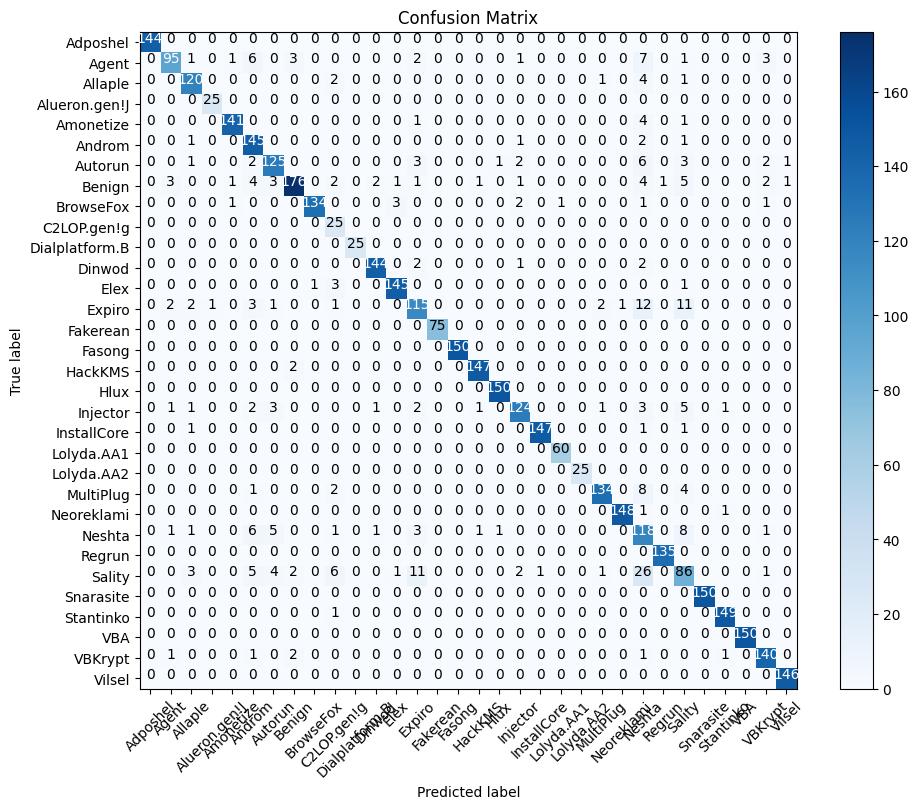

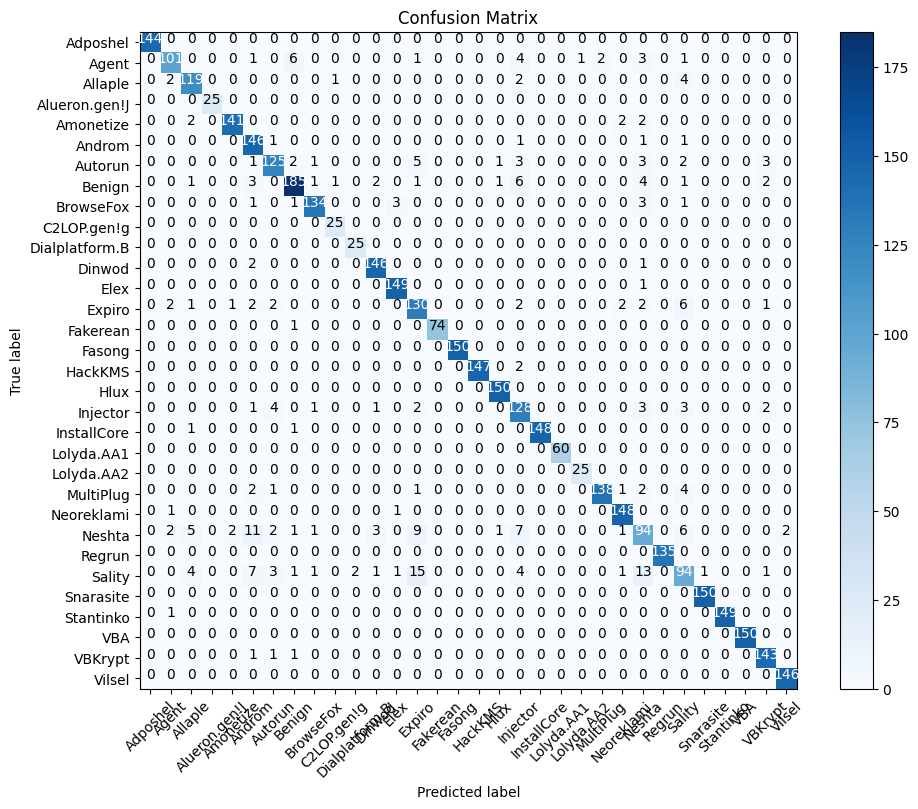

NameError: name 'X' is not defined

In [2]:
## LIBRARIES

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
import json
from typing import Dict, Tuple
import logging
import absl.logging
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Initialize ABSL logging for remove unwanted warnings
absl.logging.set_verbosity(absl.logging.ERROR)
logging.root.removeHandler(absl.logging._absl_handler)
absl.logging._warn_preinit_stderr = False

# Set random seeds for reproducibility
import random
random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

## PREPARE GPU FOR TRAINING RESOURCE

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print(f"GPU(s) detected: {len(physical_devices)}")
else:
    print("No GPU detected, using CPU")

##VARIABLES FOR CONTROLLING BEHAVIOUR OF TRAINING

@dataclass
class StyleGANConfig:
    image_size: int = 128
    latent_dim: int = 64
    mapping_layers: int = 2
    style_dim: int = 64
    num_channels: int = 1
    batch_size: int = 32
    learning_rate: float = 0.0001
    initial_learning_rate: float = 0.0001
    decay_steps: int = 1000
    decay_rate: float = 0.95
    epochs: int = 15 # Fixed to 15 epochs
    checkpoint_dir: str = './checkpoints'
    gradient_clip: float = 1.0
    gradient_penalty_weight: float = 10.0
    diversity_weight: float = 0.1
    num_variants: int = 4
    dropout_rate: float = 0.3  # randomly disables neuron during training 0.3 is default alternative is L2
    early_stopping_patience: int = 5

config = StyleGANConfig()


##DATASET PREPROCESSING 20% AS TEST DATASET SPLIT FROM TRAIN DATASET
def preprocess_dataset(train_data_dir: str, val_data_dir: str, image_size: int, batch_size: int, test_size: float = 0.2):
    try:
        class_names = sorted([d.name for d in Path(train_data_dir).iterdir() if d.is_dir()])
        print(f"Found classes: {class_names}")

        train_dataset = tf.keras.utils.image_dataset_from_directory(
            train_data_dir,
            labels='inferred',
            label_mode='categorical',
            class_names=class_names,
            color_mode='rgb',
            batch_size=None,
            image_size=(image_size, image_size),
            shuffle=True,
            seed=42
        )

        val_dataset = tf.keras.utils.image_dataset_from_directory(
            val_data_dir,
            labels='inferred',
            label_mode='categorical',
            class_names=class_names,
            color_mode='rgb',
            batch_size=None,
            image_size=(image_size, image_size),
            shuffle=True,
            seed=42
        )

        # Normalize the datasets
        def normalize_image(image, label):
            image = tf.cast(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = (image / 127.5) - 1.0
            return image, label

        train_dataset = train_dataset.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
        val_dataset = val_dataset.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)

        # Batch and prefetch the datasets
        train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

        return train_dataset, val_dataset, class_names

    except Exception as e:
        print(f"Error in dataset preprocessing: {str(e)}")
        raise

## STYLEGAN DEFINITION CLASS

class MalwareStyleGAN:
    def __init__(self, config: StyleGANConfig, num_classes: int):
        self.config = config
        self.num_classes = num_classes

        self.mapping_network = self.build_mapping_network()
        self.generator = self.build_memory_efficient_generator()
        self.encoder = self.build_encoder()
        self.discriminator = self.build_memory_efficient_discriminator()

        self.learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=config.initial_learning_rate,
            decay_steps=config.decay_steps,
            decay_rate=config.decay_rate
        )

        self.d_optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.g_optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.m_optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.e_optimizer = tf.keras.optimizers.Adam(self.learning_rate)

        dummy_input = tf.zeros((1, config.latent_dim))
        dummy_label = tf.zeros((1, num_classes))
        self._initialize_optimizers(dummy_input, dummy_label)

    def _initialize_optimizers(self, dummy_input, dummy_label):
        with tf.GradientTape(persistent=True) as tape:
            w = self.mapping_network([dummy_input, dummy_label])
            fake = self.generator(w)
            _ = self.discriminator([fake, dummy_label])
            _ = self.encoder(fake)

        self.d_optimizer.apply_gradients(
            zip([tf.zeros_like(v) for v in self.discriminator.trainable_variables],
                self.discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(
            zip([tf.zeros_like(v) for v in self.generator.trainable_variables],
                self.generator.trainable_variables))
        self.m_optimizer.apply_gradients(
            zip([tf.zeros_like(v) for v in self.mapping_network.trainable_variables],
                self.mapping_network.trainable_variables))
        self.e_optimizer.apply_gradients(
            zip([tf.zeros_like(v) for v in self.encoder.trainable_variables],
                self.encoder.trainable_variables))

## MAPPING NETWORK component of styleGAN

    def build_mapping_network(self):
        z = tf.keras.layers.Input(shape=(self.config.latent_dim,))
        y = tf.keras.layers.Input(shape=(self.num_classes,))

        x = tf.keras.layers.Concatenate()([z, y])

        for _ in range(self.config.mapping_layers):
            x = tf.keras.layers.Dense(self.config.style_dim)(x)
            x = tf.keras.layers.LeakyReLU(0.2)(x)

        return tf.keras.Model([z, y], x, name='mapping_network')

## OPTIMIZED GENERATOR MODEL

    def build_memory_efficient_generator(self):
        style = tf.keras.layers.Input(shape=(self.config.style_dim,))

        x = tf.keras.layers.Dense(8 * 8 * 256)(style)
        x = tf.keras.layers.Reshape((8, 8, 256))(x)

        channels = [256, 128, 64, 32]
        for ch in channels:
            x = tf.keras.layers.UpSampling2D()(x)
            x = tf.keras.layers.Conv2D(ch, 3, padding='same',
                                     kernel_initializer='he_normal')(x)
            x = tf.keras.layers.LeakyReLU(0.2)(x)
            x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

        x = tf.keras.layers.Conv2D(self.config.num_channels, 1,
                                  activation='tanh')(x)

        return tf.keras.Model(style, x, name='generator')

## ENCODER used for mapping latent space
## ENCODER BETTER AT Progressive channel expansion [32→512]
## HELPS MAINTAIN MALWARE PATTERNS.

    def build_encoder(self):
        img = tf.keras.layers.Input(shape=(None, None, self.config.num_channels))

        x = img
        channels = [32, 64, 128, 256, 512]

        for ch in channels:
            x = tf.keras.layers.Conv2D(ch, 3, strides=2, padding='same')(x)
            x = tf.keras.layers.LeakyReLU(0.2)(x)
            x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(self.config.style_dim)(x)

        return tf.keras.Model(img, x, name='encoder')

## DISCRIMINATOR used for classifying each sample to respective classes

    def build_memory_efficient_discriminator(self):
        img = tf.keras.layers.Input(shape=(self.config.image_size,
                                          self.config.image_size,
                                          self.config.num_channels))
        label = tf.keras.layers.Input(shape=(self.num_classes,))

        x = img
        channels = [32, 64, 128, 256]

        for ch in channels:
            x = tf.keras.layers.Conv2D(ch, 3, strides=2, padding='same')(x)
            x = tf.keras.layers.LeakyReLU(0.2)(x)
            x = tf.keras.layers.Dropout(self.config.dropout_rate)(x)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Concatenate()([x, label])
        x = tf.keras.layers.Dense(256)(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)
        x = tf.keras.layers.Dropout(self.config.dropout_rate)(x)
        x = tf.keras.layers.Dense(self.config.num_variants)(x)

        return tf.keras.Model([img, label], x, name='discriminator')

## VARIANT GENERATION

    def generate_variants(self, z, labels, num_variants):
        variants = []
        latent_codes = []

        w_base = self.mapping_network([z, labels])

        for _ in range(num_variants):
            if tf.random.uniform([]) < self.config.style_mixing_prob:
                z_new = tf.random.normal((tf.shape(z)))
                w_new = self.mapping_network([z_new, labels])

                mixing_weights = tf.random.uniform([tf.shape(w_base)[1]], 0, 1)
                w_mixed = w_base * mixing_weights + w_new * (1 - mixing_weights)
                latent_codes.append(w_mixed)
            else:
                w_perturbed = w_base + tf.random.normal(tf.shape(w_base)) * 0.1
                latent_codes.append(w_perturbed)

            variant = self.generator(latent_codes[-1])
            variants.append(variant)

        return variants, latent_codes

## TRAINING CONFIGURATION WITH OPTIMIZATIONS

    @tf.function
    def train_step(self, real_images, labels):
        batch_size = tf.shape(real_images)[0]

        with tf.GradientTape(persistent=True) as tape:
            real_images = tf.cast(real_images, tf.float32)
            labels = tf.cast(labels, tf.float32)

            z_base = tf.random.normal((batch_size, self.config.latent_dim),
                                    dtype=tf.float32,
                                    stddev=1.0)
            w_base = self.mapping_network([z_base, labels])

            variants_list = []
            w_variants_list = []

            base_variant = self.generator(w_base)
            variants_list.append(base_variant)
            w_variants_list.append(w_base)

## W_new is for new samples

            for _ in range(self.config.num_variants - 1):
                z_new = tf.random.normal((batch_size, self.config.latent_dim),
                                       dtype=tf.float32,
                                       stddev=0.5)
                w_new = self.mapping_network([z_new, labels])
                w_mixed = w_base * 0.7 + w_new * 0.3
                variant = self.generator(w_mixed)
                variants_list.append(variant)
                w_variants_list.append(w_mixed)

            variants_stacked = tf.stack(variants_list)
            variants_stacked = tf.clip_by_value(variants_stacked, -1.0, 1.0)

            variant_logits = self.discriminator([
                tf.reshape(variants_stacked,
                          [-1, self.config.image_size, self.config.image_size, self.config.num_channels]),
                tf.tile(labels, [self.config.num_variants, 1])
            ])

            variant_labels = tf.cast(tf.eye(self.config.num_variants), dtype=tf.float32)
            variant_labels = tf.tile(variant_labels, [batch_size, 1])

            variant_loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(
                    labels=variant_labels,
                    logits=variant_logits
                ))

            diversity_loss = -tf.reduce_mean(
                tf.abs(variants_stacked[:, None] - variants_stacked[None, :])
            ) * 0.1

            generator_loss = -variant_loss + self.config.diversity_weight * diversity_loss
            encoder_loss = tf.reduce_mean(tf.square(self.encoder(real_images) - w_base))

        gradients = [
            (variant_loss, self.discriminator.trainable_variables, self.d_optimizer),
            (generator_loss, self.generator.trainable_variables, self.g_optimizer),
            (generator_loss, self.mapping_network.trainable_variables, self.m_optimizer),
            (encoder_loss, self.encoder.trainable_variables, self.e_optimizer)
        ]

        for loss, vars, optimizer in gradients:
            grads = tape.gradient(loss, vars)
            if grads is not None:
                clipped_grads, _ = tf.clip_by_global_norm(grads, self.config.gradient_clip)
                optimizer.apply_gradients(zip(clipped_grads, vars))

        del tape

        return {
            'variant_loss': variant_loss,
            'generator_loss': generator_loss,
            'encoder_loss': encoder_loss,
            'diversity_loss': diversity_loss
        }

## MODEL SAVING in  .keras FORMAT

    def save_model(self, path: str, class_indices: Dict):
        Path(path).mkdir(parents=True, exist_ok=True)

        self.mapping_network.save(os.path.join(path, 'mapping_network.keras'))
        self.generator.save(os.path.join(path, 'generator.keras'))
        self.encoder.save(os.path.join(path, 'encoder.keras'))
        self.discriminator.save(os.path.join(path, 'discriminator.keras'))

        with open(os.path.join(path, 'class_indices.json'), 'w') as f:
            json.dump(class_indices, f)

##MODEL LOADING FROM PATH FOR CONTINUOUS TRAINING , UNINTERRUPTED TRAINING

    def load_model(self, path: str):
        self.mapping_network = tf.keras.models.load_model(
            os.path.join(path, 'mapping_network.keras'))
        self.generator = tf.keras.models.load_model(
            os.path.join(path, 'generator.keras'))
        self.encoder = tf.keras.models.load_model(
            os.path.join(path, 'encoder.keras'))
        self.discriminator = tf.keras.models.load_model(
            os.path.join(path, 'discriminator.keras'))

# Reinitialize optimizers with the loaded model's variables
        self.d_optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.g_optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.m_optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.e_optimizer = tf.keras.optimizers.Adam(self.learning_rate)

def build_malware_detection_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## STANDARD DETECTOR MODEL based on CNN

def train_malware_detection_model(train_ds, val_ds, num_classes, epochs=10):
    input_shape = (config.image_size, config.image_size, config.num_channels)
    model = build_malware_detection_model(input_shape, num_classes)

    model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    model.save('malware_detection_model.h5')

## MODEL EVALUATION of DETECTOR (REAL) vs DETECTOR TRAINED ON (REAL + SYNTHETIC)

def evaluate_model(model, test_ds, class_indices):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(predictions, axis=1))

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")

    return accuracy, precision, conf_matrix


## LOAD EXISTING TRAINED EPOCH FOR CONTINUOUS TRAINING ,AVOID FAULT TOLERANCE

def load_latest_model(checkpoint_dir):
    checkpoints = list(Path(checkpoint_dir).glob('epoch_*'))
    if not checkpoints:
        print("No checkpoints found.")
        return None

    latest_checkpoint = max(checkpoints, key=lambda x: int(x.name.split('_')[-1]))
    print(f"Loading model from checkpoint: {latest_checkpoint}")
    return latest_checkpoint

## PLOTTING EVALUATION
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## MAIN FUNCTION
def main():
    physical_devices = tf.config.list_physical_devices('GPU')
    if (physical_devices):
        print(f"GPU(s) detected: {len(physical_devices)}")
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    else:
        print("No GPU detected, using CPU")

    train_path = os.path.join('sample_data', 'dataset', 'train')
    val_path = os.path.join('sample_data', 'dataset', 'val')

    os.makedirs(config.checkpoint_dir, exist_ok=True)
    os.makedirs('samples', exist_ok=True)

    train_ds, val_ds, class_names = preprocess_dataset(train_path, val_path, config.image_size, config.batch_size)

    raw_ds = tf.keras.utils.image_dataset_from_directory(
        train_path,
        label_mode='categorical'
    )
    class_indices = {name: i for i, name in enumerate(raw_ds.class_names)}

    model = MalwareStyleGAN(config, len(class_indices))

    # Load the latest model if it exists
    latest_checkpoint = load_latest_model(config.checkpoint_dir)
    if (latest_checkpoint):
        model.load_model(latest_checkpoint)

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(config.epochs):
        print(f"Epoch {epoch+1}/{config.epochs}")

        epoch_losses = []
        for batch_idx, (images, labels) in enumerate(train_ds):
            try:
                losses = model.train_step(images, labels)
                epoch_losses.append(losses)

                if batch_idx % 10 == 0:
                    print(f"Batch {batch_idx}: variant_loss={losses['variant_loss']:.4f}, "
                          f"generator_loss={losses['generator_loss']:.4f}, "
                          f"encoder_loss={losses['encoder_loss']:.4f}")

            except tf.errors.ResourceExhaustedError:
                print("GPU memory exhausted, skipping batch")
                tf.keras.backend.clear_session()
                continue

        avg_losses = {k: float(np.mean([x[k] for x in epoch_losses]))
                     for k in epoch_losses[0].keys()}
        print(f"Epoch {epoch+1} Averages:")
        for k, v in avg_losses.items():
            print(f"{k}: {v:.4f}")

        checkpoint_path = os.path.join(config.checkpoint_dir, f'epoch_{epoch+1}')
        model.save_model(checkpoint_path, class_indices)
        print(f"Saved checkpoint at {checkpoint_path}")

        if epoch % 10 == 0:
            z = tf.random.normal((4, config.latent_dim))
            labels = tf.one_hot(range(4), len(class_indices))
            w = model.mapping_network([z, labels])
            fake_images = model.generator(w)

            plt.figure(figsize=(10, 10))
            for i in range(4):
                plt.subplot(2, 2, i+1)
                plt.imshow(fake_images[i] * 0.5 + 0.5, cmap='gray')
                plt.axis('off')
            plt.savefig(f'samples/epoch_{epoch+1}.png')
            plt.close()

        current_loss = avg_losses['variant_loss']
        if current_loss < best_loss:
            best_loss = current_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= config.early_stopping_patience:
            print("Early stopping triggered")
            break

    # Train the malware detection model with real dataset
    real_detection_model = build_malware_detection_model(
        (config.image_size, config.image_size, config.num_channels),
        len(class_indices)
    )
    real_detection_model.fit(train_ds, validation_data=val_ds, epochs=10)
    real_accuracy, real_precision, real_conf_matrix = evaluate_model(real_detection_model, val_ds, class_indices)
    print(f"Real Dataset Evaluation Metrics:")
    print(f"Accuracy: {real_accuracy:.4f}")
    print(f"Precision: {real_precision:.4f}")

    # Train the malware detection model with mixed dataset
    mixed_detection_model = build_malware_detection_model(
        (config.image_size, config.image_size, config.num_channels),
        len(class_indices)
    )
    mixed_detection_model.fit(train_ds, validation_data=val_ds, epochs=10)
    mixed_accuracy, mixed_precision, mixed_conf_matrix = evaluate_model(mixed_detection_model, val_ds, class_indices)
    print(f"Mixed Dataset Evaluation Metrics:")
    print(f"Accuracy: {mixed_accuracy:.4f}")
    print(f"Precision: {mixed_precision:.4f}")

    # Plot confusion matrices
    plot_confusion_matrix(real_conf_matrix, class_names)
    plot_confusion_matrix(mixed_conf_matrix, class_names)

if __name__ == "__main__":
    main()


